In [74]:
import pandas as pd
import numpy as np
import yfinance as yf
import ta
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout



# Define stock ticker and date range
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2024-12-31'

# Download data
data = yf.download(ticker, start=start_date, end=end_date)

# Display first few rows
print(data.head())
# Display last few rows
print(data.tail())


C:\Users\Mohammad Alfaiz\AppData\Local\Temp\ipykernel_23432\705401867.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.288572  24.757327  23.848698  24.746218  212818400
2015-01-05  23.604334  24.137514  23.417722  24.057537  257142000
2015-01-06  23.606554  23.866479  23.244435  23.668758  263188400
2015-01-07  23.937569  24.037539  23.704302  23.815381  160423600
2015-01-08  24.857307  24.915069  24.148621  24.266367  237458000
Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2024-12-23  254.655716  255.034791  252.840088  254.156919  40858800
2024-12-24  257.578674  257.588630  254.675658  254.875189  23234700
2024-12-26  258.396667  259.474086  257.010028  257.568678  27237100
2024-12-27  254.974930  258.077462  252.451019  257.209530

In [75]:
data.info()  # Display information about the DataFrame

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2015-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   2515 non-null   float64
 1   (High, AAPL)    2515 non-null   float64
 2   (Low, AAPL)     2515 non-null   float64
 3   (Open, AAPL)    2515 non-null   float64
 4   (Volume, AAPL)  2515 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.9 KB


In [76]:
# Averages the last 20 days(Moving Average) to smooth out noise in price
data['MA20'] = data['Close'].rolling(window=20).mean()

In [77]:
# Calculate the Relative Strength Index (RSI)
data['RSI'] = ta.momentum.RSIIndicator(close=data['Close'].squeeze(), window=14).rsi()

In [78]:
data = data.dropna()  # Drop rows with NaN values

In [79]:
print(data[['Close', 'MA20', 'RSI']].head())

Price           Close       MA20        RSI
Ticker           AAPL                      
Date                                       
2015-01-30  26.028080  24.579941  63.366902
2015-02-02  26.354654  24.683245  65.630045
2015-02-03  26.359104  24.820984  65.661175
2015-02-04  26.561266  24.968720  67.118263
2015-02-05  26.750843  25.109383  68.469415


In [80]:
# Select relevant features for scaling
features = data[['Close', 'MA20', 'RSI']]

# Create scaler and fit on data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)

# Convert back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=['Close', 'MA20', 'RSI'], index=data.index)
print(scaled_df.head())

               Close      MA20       RSI
Date                                    
2015-01-30  0.022632  0.013768  0.607717
2015-02-02  0.024005  0.014222  0.640202
2015-02-03  0.024024  0.014829  0.640649
2015-02-04  0.024874  0.015479  0.661565
2015-02-05  0.025672  0.016098  0.680960


In [81]:
# Prepare data for LSTM
X = []
y = []

time_step = 60  

for i in range(time_step, len(scaled_df)):
    X.append(scaled_df.iloc[i - time_step:i].values)  # 60-day sequence
    y.append(scaled_df.iloc[i]['Close'])              # Next day close price

X, y = np.array(X), np.array(y)
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (2436, 60, 3)
y shape: (2436,)


In [82]:
# Split the data into training and testing sets
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [83]:
# Build the LSTM model
model = Sequential()

# First LSTM layer (returns sequences to stack more layers)
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout prevents overfitting

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))  # Predicting the 'Close' price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


d:\Anaconda\envs\yd\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [84]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0233 - val_loss: 0.0098
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0022 - val_loss: 9.0534e-04
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 9.7553e-04 - val_loss: 0.0015
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss: 9.2109e-04 - val_loss: 9.9567e-04
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 8.2979e-04 - val_loss: 9.3316e-04
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 7.8989e-04 - val_loss: 0.0018
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 9.1911e-04 - val_loss: 7.8968e-04
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 8.6149e-04 - val_loss: 6.5398e-04
Epoch 12/20
31/31 

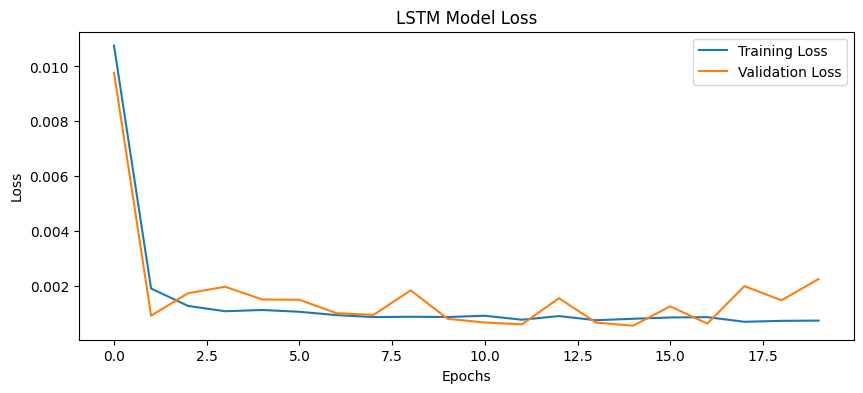

In [85]:
# Plotting the training and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("LSTM Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [86]:
# Predicting on the test set
predicted_scaled = model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


In [89]:
# Reshape to match scaler input: (samples, features)
# Combine predicted close with dummy MA20 and RSI (zeros), then inverse transform
predicted = scaler.inverse_transform(
    np.hstack((predicted_scaled, np.zeros((len(predicted_scaled), 2))))
)[:, 0]

# Do the same for actual y_test
actual = scaler.inverse_transform(
    np.hstack((y_test.reshape(-1, 1), np.zeros((len(y_test), 2))))
)[:, 0]


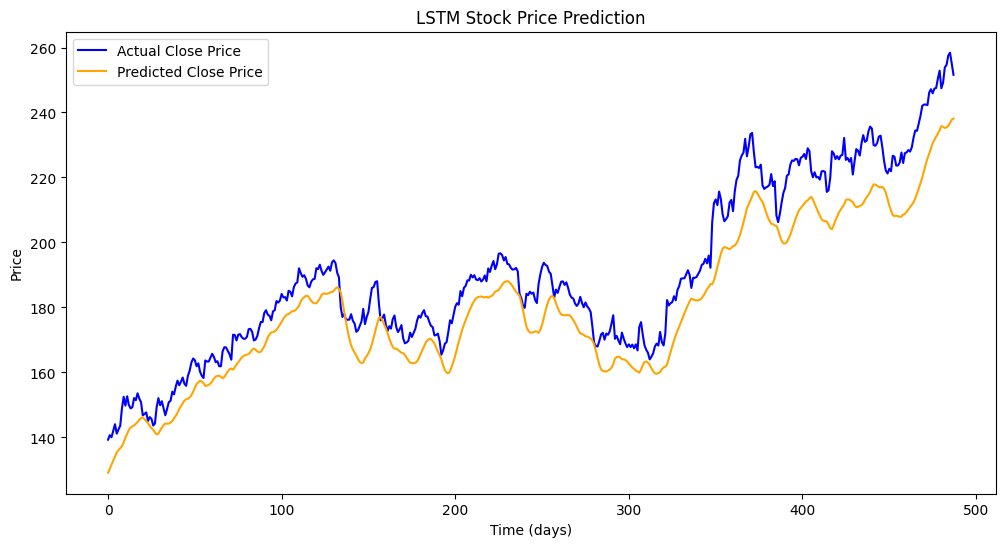

In [90]:
# Plotting the actual vs predicted prices
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(actual, label='Actual Close Price', color='blue')
plt.plot(predicted, label='Predicted Close Price', color='orange')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Time (days)')
plt.ylabel('Price')
plt.legend()
plt.show()


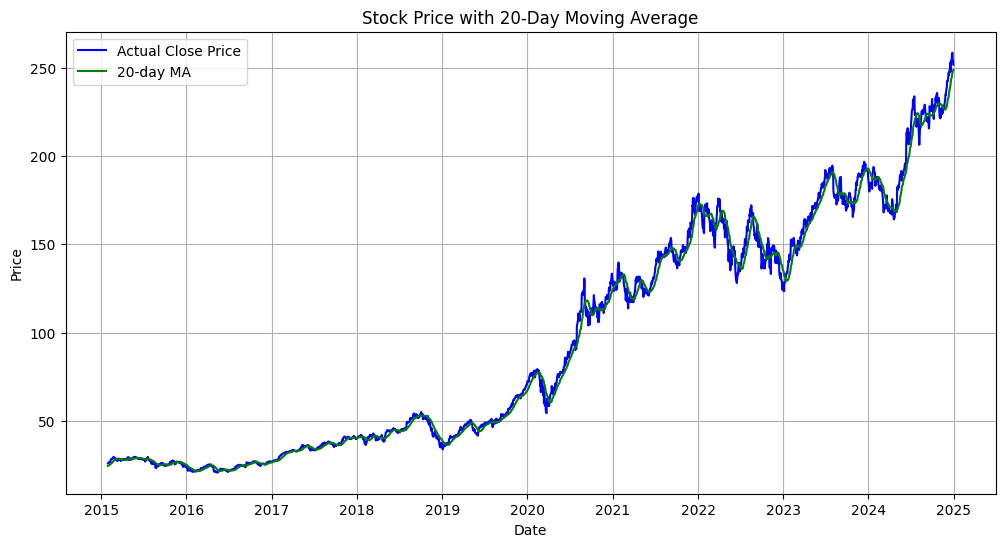

In [91]:
# Plotting the stock price with 20-day moving average
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Actual Close Price', color='blue')
plt.plot(data['MA20'], label='20-day MA', color='green')
plt.title("Stock Price with 20-Day Moving Average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


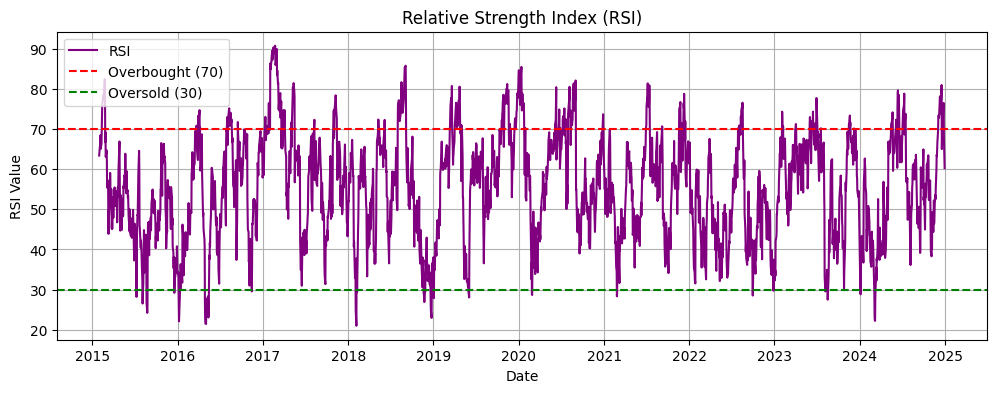

In [92]:
# Plotting the Relative Strength Index (RSI)
plt.figure(figsize=(12,4))
plt.plot(data['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title("Relative Strength Index (RSI)")
plt.xlabel("Date")
plt.ylabel("RSI Value")
plt.legend()
plt.grid(True)
plt.show()
